## data_driven 2021.9.28

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  
# LSTM + local attention + global attention

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 1
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径
DOCUMENT_RESULT_PATH = 'results/prediction/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'datadriven_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 6

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01
    
##############################数据集读取########################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))

############################################################小波分析##########################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
#         print('self.u_query', np.shape(self.u_query))
#         print('key', np.shape(key))
        scores = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global(feature_local)
print('feature', np.shape(feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq], 
                         outputs=wear_predict, name='tool_wear_predictor')
predictor.summary()
#############################################模型训练#########################################################################

time_start = time.time()
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, mode='auto')

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])

# predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9792, 1536, 3) -1.0226240158081055 0.8822135925292969
Y_train (9792,) 0.18163076 0.87186223
X_test (1024, 1536, 3)
Y_test (1024,)
coeffs_lowfreq_train (9792, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9792, 1536, 3) -0.8882813551840282 0.7132884507306377
coeffs_lowfreq_test (1024, 192, 3) -1.4341723166027973 1.6138990016487686
coeffs_highfreq_test (1024, 1536, 3) -0.4703053545347131 0.4908650818103628
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 192, 3)]       0                                   

coeffs_lowfreq_train (9792, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9792, 1536, 3) -0.8882813551840282 0.7132884507306377
coeffs_lowfreq_test (1024, 192, 3) -1.4341723166027973 1.6138990016487686
coeffs_highfreq_test (1024, 1536, 3) -0.4703053545347131 0.4908650818103628
loss_train_avg 0.0015691863
percent_train_avg 7.571963220834732 %
mFPE 2.5080284476280212
MFPE 19.53727960586548


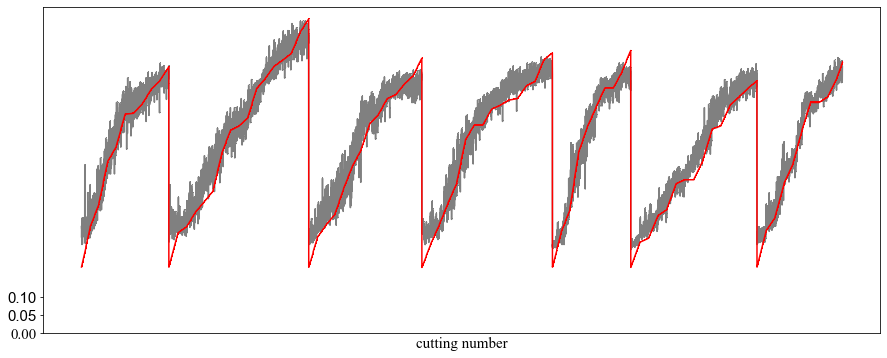

time1 =   1.8313853740692139 sample_num 1024
loss_test_avg 0.0039372058
percent_test_avg 9.1169074177742 %
mFPE 3.608136475086212
MFPE 20.990355014801025


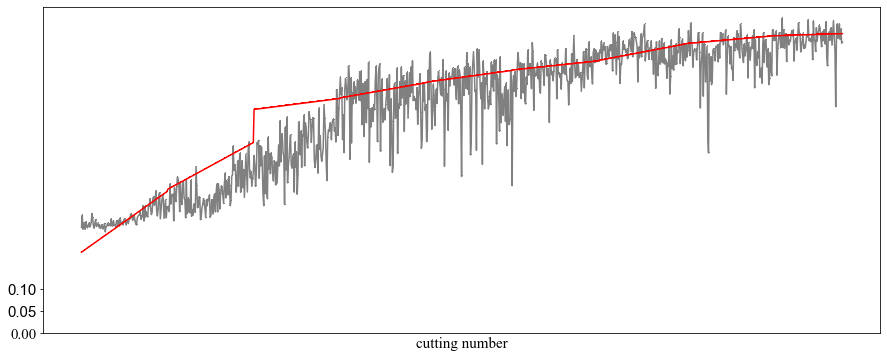

complete


In [2]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 1
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/prediction/'+str(file_index)+'/'
MODEL_LOADPATH = DOCUMENT_RESULT_PATH + 'datadriven_model.h5'
RESULT_SAVEPATH = DOCUMENT_RESULT_PATH + 'datadriven_result.npy'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8
#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]
SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
ATTENTION_RANGE = 24
WEAR_SIZE = 1
BATCH_SIZE = 64


#画图，输出训练和测试曲线
load_flag = 1
if load_flag == 1:
    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]
    
    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
    print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]
    print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
    print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))   
    
    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
            super(temporal_Attention,self).build(input_shape)
        def call(self, key): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
    #         print('self.u_query', np.shape(self.u_query))
    #         print('key', np.shape(key))
            scores = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    predictor = keras.models.load_model(MODEL_LOADPATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                        'temporal_Attention':temporal_Attention})


fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
# score = predictor.evaluate([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train], Y_train, verbose=0, batch_size = BATCH_SIZE)
Y_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train], batch_size = BATCH_SIZE)

axis = np.linspace(1, np.shape(Y_pre_train)[0], np.shape(Y_pre_train)[0])
print('loss_train_avg', np.mean(np.square(Y_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(Y_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
print('mFPE', np.mean(np.abs(Y_pre_train[:, 0] - Y_train))*80)
print('MFPE', np.max(np.abs(Y_pre_train[:, 0] - Y_train))*80)

plt.plot(axis, Y_pre_train,color = 'gray', marker = ',', label = 'predicted result')
plt.plot(axis, Y_train,'r',marker = ',',label = 'actual tool wear')
plt.xticks([])
plt.yticks([0.0, 0.05, 0.1], fontproperties = 'Times New Roman', size = size)   
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
# plt.savefig(DOCUMENT_RESULT_PATH + 'train_output.png', dpi = 300)
plt.show()

#test
# score = predictor.evaluate([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test], Y_test, verbose=0, batch_size = BATCH_SIZE)
time_start = time.time()
Y_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(Y_pre_test)[0])

axis = np.linspace(1, np.shape(Y_pre_test)[0], np.shape(Y_pre_test)[0])
print('loss_test_avg', np.mean(np.square(Y_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(Y_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
print('mFPE', np.mean(np.abs(Y_pre_test[:, 0] - Y_test))*80)
print('MFPE', np.max(np.abs(Y_pre_test[:, 0] - Y_test))*80)
        
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}
plt.plot(axis, Y_pre_test,color = 'gray', marker = ',', label = 'predicted result')
plt.plot(axis, Y_test,'r',marker = ',',label = 'actual tool wear')
plt.xticks([])
plt.yticks([0.0, 0.05, 0.1], fontproperties = 'Times New Roman', size = size)   
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.png', dpi = 300)
plt.show()

np.save(RESULT_SAVEPATH, Y_pre_test[:, 0])
print('complete')